In [5]:
from sclibrary.network_reader import NetworkReader
from sclibrary.simplicial_complex import SimplicialComplexNetwork
from sclibrary.plot import SCPlot
import numpy as np
import matplotlib.pyplot as plt

from sclibrary.eigendecomposition import get_eigendecomposition

### Reading data

In [6]:
data_folder = 'data/paper_data'

# read csv
filename = data_folder + '/edges.csv'
delimeter = " "
src_col = 'Source'
dest_col = 'Target'
feature_cols = ['Distance']

G = NetworkReader.read_csv(filename=filename, delimeter=delimeter, 
                           src_col=src_col, dest_col=dest_col, feature_cols=feature_cols)

simplices = G.simplicies(condition="distance", dist_col_name="Distance", dist_threshold=1.5)

# coordinates
filename = data_folder + '/coordinates.csv'
coordinates = NetworkReader.get_coordinates(filename=filename, 
                                            node_id_col="Id", 
                                            x_col='X', 
                                            y_col='Y', 
                                            delimeter=" ")


# create a simplicial complex network
sc = SimplicialComplexNetwork(simplices=simplices)
scplot = SCPlot(sc, coordinates)

### Chebyshev filter design

In [7]:
L1 = sc.hodge_laplacian_matrix(rank=1)
L1L = sc.lower_laplacian_matrix(rank=1)

U1, eigenvals_U1 = get_eigendecomposition(L1)
U1L, eigenvals_U1L = get_eigendecomposition(L1L)

In [8]:
# f0 = np.array([
#     2.25,
#     0.13,
#     1.72,
#     -2.12,
#     1.59,
#     1.08,
#     -0.30,
#     -0.21,
#     1.25,
#     1.45,
# ])

# f = np.array([
#     2.90,
#     0.25, 
#     1.78,
#     -1.50,
#     1.76,
#     1.53,
#     1.32,
#     0.08,
#     0.67, 
#     1.73
# ])

f = np.array([
    0.2851,
    -0.8824,
    -1.3731,
    1.2467,
    -0.9050,
    0.7202,
    0.5628,
    -1.1828,
    1.3918,
    0.8425
])

In [9]:
# approx largest true eigenvalue using power iteration method
# power iteration
v = np.ones(L1.shape[0])
for i in range(50):
    v = L1 @ v
    v = v / np.linalg.norm(v)
v

array([ 0.05882426, -0.32941538,  0.14631812, -0.38823965,  0.4757335 ,
        0.49026405, -0.30516876,  0.31969932,  0.12266404, -0.19703528])

In [10]:
_, _, f_g = sc.get_hodgedecomposition(flow=f)

print(f)
print(f_g)

[ 0.2851 -0.8824 -1.3731  1.2467 -0.905   0.7202  0.5628 -1.1828  1.3918
  0.8425]
[-0.64 -0.31 -1.02  0.32 -0.71  0.17  1.11 -0.24  1.    1.24]


In [207]:
# estimate largest eigenvalue using power iteration method
v = np.ones(L1L.shape[0])
for i in range(50):
    v = L1L @ v
    v = v / np.linalg.norm(v)

print("v", v)
# mean of the largest eigenvalue
lamda_g_max = np.mean(L1L @ v / v)
print("lamda_g_max", lamda_g_max)

v [ 0.05882426 -0.32941538  0.14631812 -0.38823965  0.4757335   0.49026405
 -0.30516876  0.31969932  0.12266404 -0.19703528]
lamda_g_max 5.4879826825028015


In [208]:
from chebpy import chebfun

# cut off frequency - gradient
cut_off_freq_g = 0.1
steep = 10

# logistic function to perform gradient component extraction
g_g = lambda lam: 1 / (1 + np.exp(-steep * (lam - cut_off_freq_g)))
g_g_cheb = chebfun(g_g, [0, lamda_g_max], 10)

# filter coefficients
coeffs_g = g_g_cheb.funs[0].coeffs
coeffs_g

array([ 0.92090631,  0.15337579, -0.13960124,  0.11872732, -0.09350122,
        0.06711492, -0.0427504 ,  0.02319648, -0.01058273,  0.00311478])

Text(0.5, 1.0, 'Frequency response on the gradient eigen_values - chebyshev approx.')

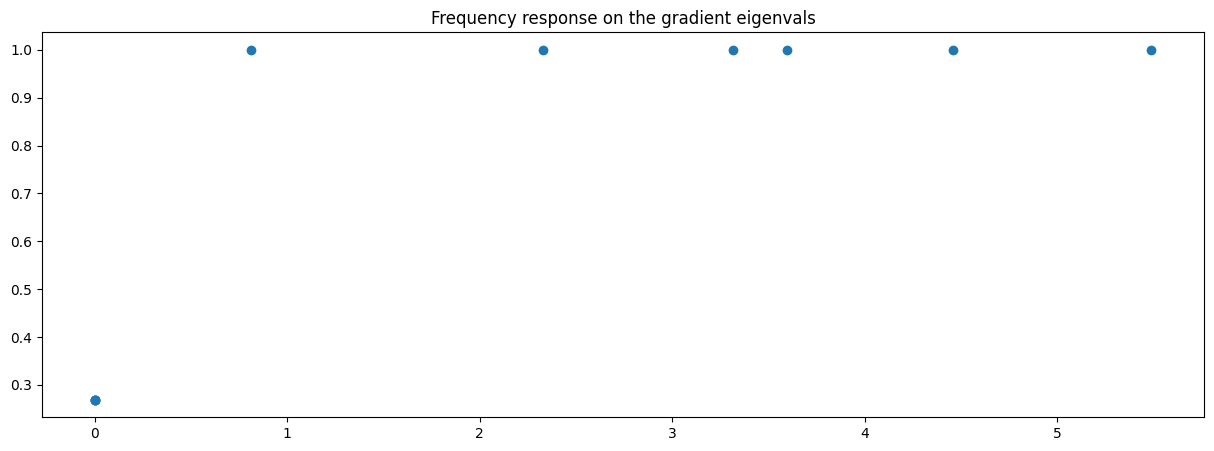

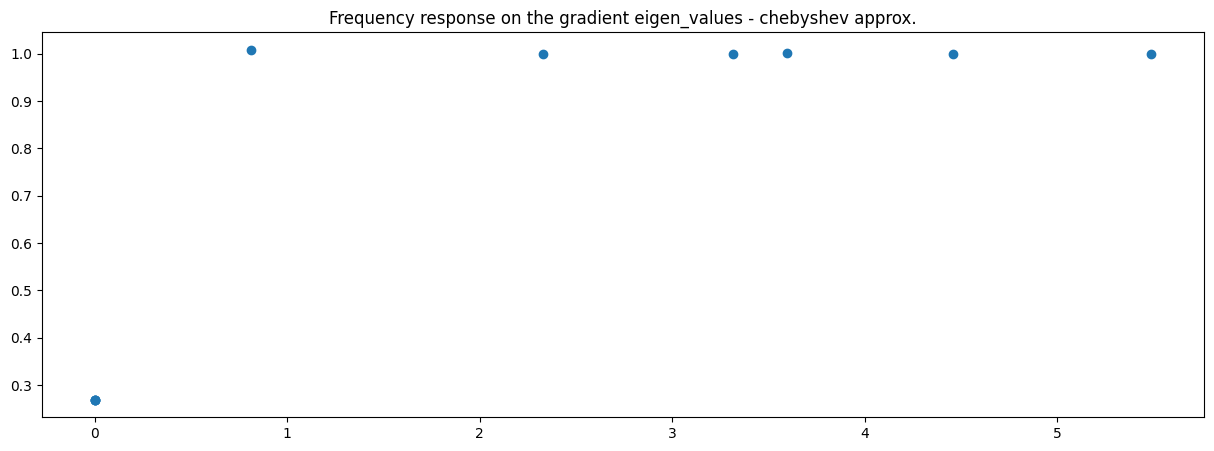

In [209]:
# plot the continuous frequency response 
plt.figure(figsize=(15, 5))
plt.scatter(eigenvals_U1L, g_g(eigenvals_U1L))
plt.title("Frequency response on the gradient eigenvals")

plt.figure(figsize=(15, 5))
plt.scatter(eigenvals_U1L, g_g_cheb(eigenvals_U1L))
plt.title("Frequency response on the gradient eigen_values - chebyshev approx.")

difference 1.913538576985806


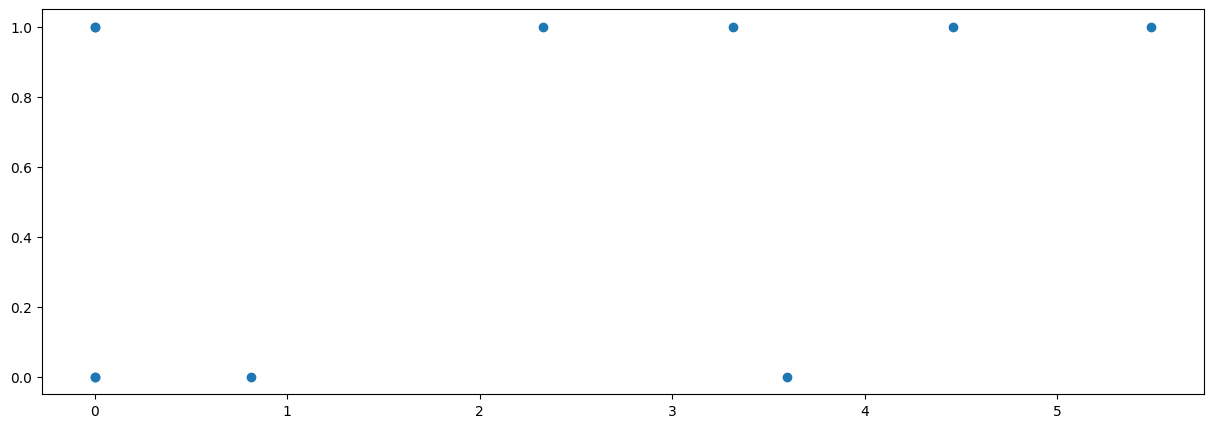

In [210]:
component = "gradient"

# the ideal frequency response
u_g, _ = sc.get_eigendecomposition(component)
h_g_ideal = sc.get_component_coefficients(component)
H_g_ideal = U1L @ np.diag(h_g_ideal) @ U1L.T

# difference 
print("difference", np.linalg.norm(H_g_ideal - u_g @ u_g.T))

# pplo the ideal frequency response
plt.figure(figsize=(15, 5))
plt.scatter(eigenvals_U1L, h_g_ideal)

In [282]:
import numpy as np
# perform a transformation to shit the domain to [0, lambda_g_max]
alpha_g = lamda_g_max / 2
points = (eigenvals_U1L - alpha_g) / alpha_g

def chebyshev_approx(l1, L1L):
    if l1 == 0:
        return np.eye(L1L.shape[0])
    elif l1 == 1:
        return (2 / lamda_g_max) * L1L - np.eye(L1L.shape[0])
    else:
        return 2 * chebyshev_approx(1, L1L) @ chebyshev_approx(l1 - 1, L1L) - chebyshev_approx(l1-2, L1L) 
    
    
# implement
# Hl = (1/2) * c(l, 0) * I + sum(l1=1, L) c(l, l1) * P(l1)(L1L)
def calculate_Hl(c, L1L, k):
    #I = np.eye(L1L.shape[0])
    
    Hl = np.zeros_like(L1L)
    #Hl = (1/2) * c[0]
    
    for l1 in range(k):
        Hl += c[l1] * chebyshev_approx(l1, L1L)
        
    return Hl

calculate_Hl(coeffs_g, L1L, 9)

array([[ 0.724419  ,  0.17486183,  0.1004068 , -0.27750093, -0.07445502,
        -0.02846242,  0.02735879,  0.01863381,  0.00946296, -0.00917085],
       [ 0.17486183,  0.62194735,  0.20332424,  0.17502935, -0.14656696,
        -0.05377022,  0.05598873,  0.03680798,  0.01929157, -0.01751641],
       [ 0.1004068 ,  0.20332424,  0.6970601 ,  0.10291743,  0.22167973,
         0.08445115, -0.08140736, -0.05582121, -0.02735879,  0.02846242],
       [-0.27750093,  0.17502935,  0.10291743,  0.7245865 , -0.07211192,
        -0.02530781,  0.02862994,  0.01817417,  0.0098286 , -0.00834557],
       [-0.07445502, -0.14656696,  0.22167973, -0.07211192,  0.64030284,
         0.13822138, -0.1373961 , -0.09262919, -0.04665036,  0.04597883],
       [-0.02846242, -0.05377022,  0.08445115, -0.02530781,  0.13822138,
         0.7816788 ,  0.22483432,  0.14656696,  0.0752803 , -0.07128663],
       [ 0.02735879,  0.05598873, -0.08140736,  0.02862994, -0.1373961 ,
         0.22483432,  0.78151125, -0.1472247 

In [283]:
import numpy as np

# truncated order 
K_trunc = range(10)

H_g_cheb_approx_out = np.zeros((len(K_trunc), L1L.shape[0], L1L.shape[1]))

for k in range(len(K_trunc)):
    H_g_cheb_approx_out[k:, :, :] = calculate_Hl(coeffs_g, L1L, k)
    
H_g_cheb_approx_out[0, :, :]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [285]:
errors_g_response = np.zeros((len(K_trunc)))
errors_filter = np.zeros((len(K_trunc)))

f_g_cheb = np.zeros((L1L.shape[0], len(K_trunc)))
f_g_cheb_tilde = np.zeros((L1L.shape[0], len(K_trunc)))

error_g_tilde = np.zeros((len(K_trunc)))
error_g = np.zeros((len(K_trunc)))

for k in range(len(K_trunc)):
    g_g_cheb_approx = np.diag(U1L.T @ np.squeeze(H_g_cheb_approx_out[k, :, :]) @ U1L)
    # compute the error
    errors_g_response[k] = np.linalg.norm(g_g_cheb_approx - h_g_ideal) / np.linalg.norm(h_g_ideal)
    errors_filter[k] = np.linalg.norm(np.squeeze(H_g_cheb_approx_out[k, :, :]) - H_g_ideal, 2)
    
    f_g_cheb[:, k] = np.squeeze(H_g_cheb_approx_out[k, :, :]) @ f
    f_g_cheb_tilde[:, k] = U1 @ f_g_cheb[:, k]
    
    error_g_tilde[k] = np.linalg.norm(f_g_cheb_tilde[:, k] - U1.T * f_g) / np.linalg.norm(U1.T * f_g)
    error_g[k] = np.linalg.norm(f_g_cheb[:, k] - f_g) / np.linalg.norm(f_g)
    
errors_filter


array([1.23134324, 0.92090631, 0.96864623, 1.08119735, 0.98465314,
       0.99337666, 1.03951722, 1.03811305, 1.02109419, 1.01052161])

In [286]:
errors_g_response

array([1.        , 0.7169071 , 0.67856973, 0.69591083, 0.69084978,
       0.71197287, 0.74620819, 0.74939702, 0.74540442, 0.74692958])

In [287]:
error_g_tilde, error_g

(array([1.        , 3.7030594 , 3.58079245, 3.52605471, 3.39630104,
        3.26920947, 3.31413671, 3.26614759, 3.25882018, 3.24333921]),
 array([1.        , 0.75634488, 0.6342439 , 0.52177719, 0.42077996,
        0.34177646, 0.28655226, 0.25115117, 0.2316593 , 0.22281602]))

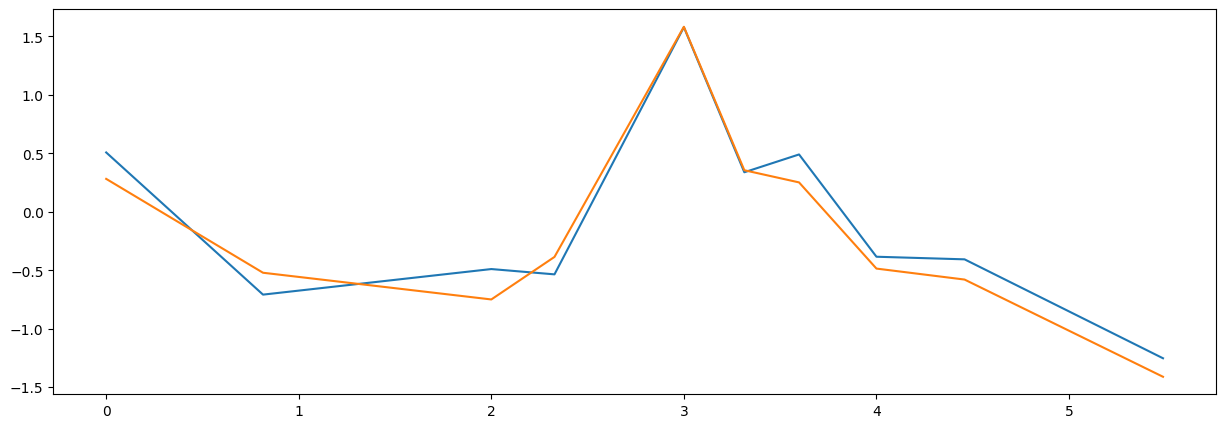

In [288]:
plt.figure(figsize=(15, 5))
plt.plot(eigenvals_U1, U1@f_g)
plt.plot(eigenvals_U1, f_g_cheb_tilde[:, -1])